In [1]:
# makemore built by training an multi-layer perceptron MLP

In [2]:
import random
special_token = '.'
words = open('names.csv', 'r').read().splitlines()
words = [s.lower() for s in words] 
seed = 2147483647
random.seed(seed)

In [3]:
words[:10]

['aaban',
 'aabha',
 'aabid',
 'aabidah',
 'aabir',
 'aabriella',
 'aada',
 'aadam',
 'aadan',
 'aadarsh']

In [4]:
# learning some statistical properties about the dataset
len(words), min(len(w) for w in words), max(len(w) for w in words)

(101338, 2, 15)

In [5]:
#build vocabulary
def vocabulary(words):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos, len(stoi)

stoi, itos, vocab_size = vocabulary(words)
special_idx = stoi['.']

In [6]:
# build dataset
import torch
import torch.nn.functional as F
torch.cuda.empty_cache()
device = torch.device("cpu") # "cuda:0" if torch.cuda.is_available() else "cpu"
g = torch.Generator(device=device).manual_seed(seed)
torch.set_default_tensor_type(torch.FloatTensor) # torch.cuda.FloatTensor

block_size = 3 #how many chars to use in our prediction

def build_dataset(words):
    X, Y = [], [] #inputs and labels

    for w in words:
        context = [special_idx] * block_size #context starts as ". . ."
        for ch in w + special_token:
            ix = stoi[ch] # retrieve index for char from vocab
            X.append(context) #add current example, starting with ". . ."
            Y.append(ix) #the label is the next char (or first, or . for last)
            context = context[1:] + [ix] #cropping first char as window slides and another char is added

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'{X.shape=}, {Y.shape=}')
    
    return X, Y

In [7]:
train=0.8
dev=0.1

random.seed(seed)
random.shuffle(words)

n1 = int(train*len(words))
n2 = int((train+dev)*len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%


X.shape=torch.Size([609946, 3]), Y.shape=torch.Size([609946])
X.shape=torch.Size([76390, 3]), Y.shape=torch.Size([76390])
X.shape=torch.Size([76486, 3]), Y.shape=torch.Size([76486])


In [8]:
# this is the model
class MLP():

    def __init__(self, vocab, block_size):
        embd_dim = 10
        hidden_dim = 200
        self.block_size = block_size
        vocab_size = len(vocab)
        self.C = torch.randn((vocab_size, embd_dim), generator=g) #the matrix that takes chars and outputs embeddings
    
        # first layer of a MLP
        self.W1 = torch.randn(( block_size*embd_dim, hidden_dim), generator=g) #proportional to block_size so emb.view() matches
        self.b1 = torch.randn(hidden_dim, generator=g)
        #second layer
        self.W2 = torch.randn((hidden_dim, vocab_size), generator=g) #ultimately we need to predict one of 27 chars
        self.b2 = torch.randn(vocab_size, generator=g)

        # aggregate parameters and turn on gradient for all
        self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        for p in self.parameters: p.requires_grad = True
        print( f'MLP instantiated with {sum(p.nelement() for p in self.parameters)} parameters')

    # forward pass
    def forward(self, X, Y):
        self.emb = self.C[X] # embedings of input (eg batch_size=32, block_size=3, emb_depth=10)
        # non linearity
        self.h = torch.tanh( self.emb.view(-1, self.W1.shape[0]) @ self.W1 + self.b1 )
        self.logits = self.h @ self.W2 + self.b2

        #softmax
        # counts = logits.exp()
        # prob = counts / counts.sum(1, keepdims=True)

        #loss => log likelihood
        #get the probability for each value of Y, then take -log and average
        #arange is just a trick to pluck the relevant prob of char Y for each example
        # loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
        
        # all of the above can be replaced with cross_entropy loss
        self.loss = F.cross_entropy(self.logits, Y)
        return self.loss

    def backward(self, lr=0.1):
        #clear old gradients
        for p in self.parameters:
            p.grad = None

        self.loss.backward()

        #update params
        for p in self.parameters:
            p.data += -lr * p.grad

    @torch.no_grad() # this decorator disables gradient tracking
    def generate(self, q=20):
        emb = None
        for _ in range(q):
            out = []
            context = [special_idx] * self.block_size # initialize as ...
            while True:
                emb = self.C[torch.tensor([context])] #(1 example, block_size chars, emb_depth))
                h = torch.tanh(emb.view(1, -1) @ self.W1 + self.b1)
                logits = h @ self.W2 + self.b2
                probs = F.softmax(logits, dim=1)
                ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
                context = context[1:] + [ix] #keep shifting context (the input)
                out.append(ix)
                if ix == 0:
                    break
            print(''.join(itos[i] for i in out))




In [9]:
model = MLP(stoi, block_size) 

#stats
lri = []
lossi = []
stepi = []


MLP instantiated with 11897 parameters


In [10]:
# this is the trainer
import time
start_time = time.time()
passes = 200_000
batch_size = 512 #batches smaller than 1024 are faster on my CPU than GPU
lre = torch.linspace(0, -4, passes) #decaying learning rate
lrs = 10**lre


for i in range(passes):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,)) #batch_size random integers within Xtr[0] range, 1 dim tensor

    #forward pass
    loss = model.forward(Xtr[ix], Ytr[ix])
    if i%(passes/10)==0:
        print(f'{loss=}')

    #backward pass
    model.backward(lrs[i])

    #statsg = torch.Generator().manual_seed(seed)
    stepi.append(i)
    lossi.append(loss.log10().item())

elapsed_time = time.time() - start_time
print("Total time: {:.2f} seconds".format(elapsed_time))

loss=tensor(26.3969, grad_fn=<NllLossBackward0>)
loss=tensor(2.2927, grad_fn=<NllLossBackward0>)
loss=tensor(2.1672, grad_fn=<NllLossBackward0>)
loss=tensor(2.1798, grad_fn=<NllLossBackward0>)
loss=tensor(2.1791, grad_fn=<NllLossBackward0>)
loss=tensor(2.1240, grad_fn=<NllLossBackward0>)
loss=tensor(2.1994, grad_fn=<NllLossBackward0>)
loss=tensor(2.1273, grad_fn=<NllLossBackward0>)
loss=tensor(2.1874, grad_fn=<NllLossBackward0>)
loss=tensor(2.1075, grad_fn=<NllLossBackward0>)
Total time: 132.44 seconds


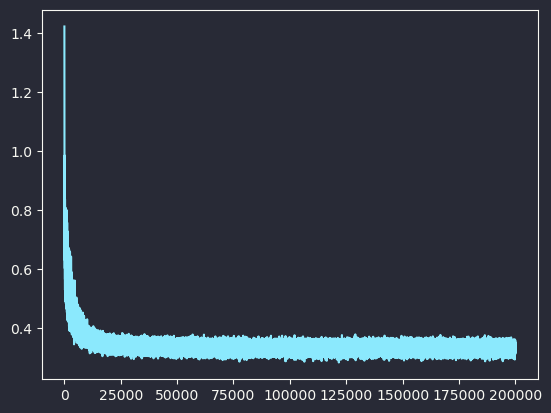

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(stepi, lossi)

In [12]:
# check loss with dev dataset
model.forward(Xdev, Ydev)

tensor(2.1642, grad_fn=<NllLossBackward0>)

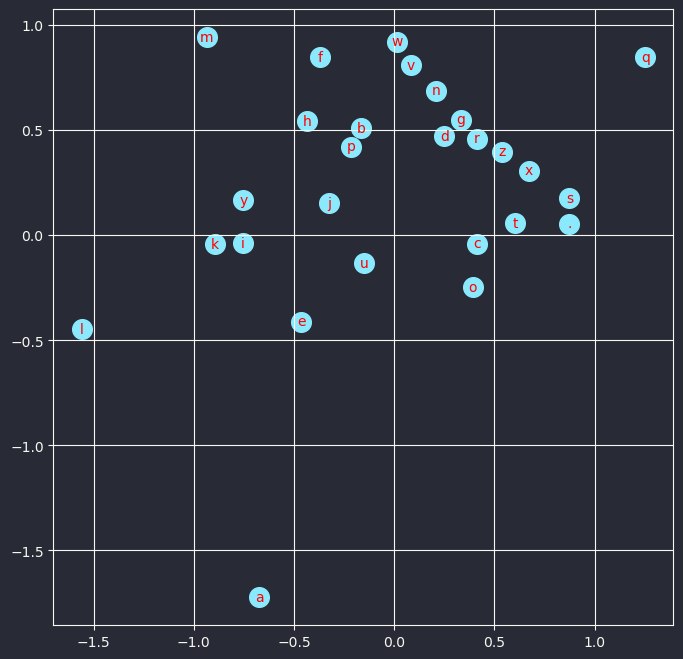

In [13]:
# visualize dimensions idx1 and idx2 for 1st dimm of embedding matrix C (27, 10) for all characters in vocab
idx1 = 3
idx2 = 7
plt.figure(figsize=(8,8))
plt.scatter(model.C[:,idx1].data, model.C[:,idx2].data, s=200)
for i in range(model.C.shape[0]):
    plt.text(model.C[i,idx1].item(), model.C[i,idx2].item(), itos[i], ha="center", va="center", color="red")
plt.grid('minor')

In [14]:
model.generate()

wylquline.
thencie.
daurinvel.
coke.
syl.
raw.
edpestavy.
raiya.
delynn.
williesy.
tazsa.
ivand.
jaleighael.
olett.
eshanyreajase.
xainnleen.
shakiyannis.
wrysse.
nia.
fresmarciaelixany.
